In [1]:
from numpy import *
#Import all numpy functions for array operations

In [2]:
## Step 1: Define intrinsic parameters (internal camera properties)
a_u = 557.0943
a_v = 712.9824
u_0 = 326.3819
v_0 = 298.6679
gamma = 0
# Location of the world reference frame in camera coordinates in mm
Tx = 100
Ty = 0
Tz = 1500
# Euler angles for world-to-camera rotation (XYX1 convention)
Phix = 0.8*pi/2
Phiy = -1.8*pi/2
Phix1 = pi/5

In [3]:
# Step 2: Create the 3x3 intrinsic matrix K
K = array([[a_u, gamma, u_0],
          [0, a_v, v_0],
          [0, 0, 1]])
K.shape

(3, 3)

In [4]:
# Display the K matrix
K

array([[557.0943,   0.    , 326.3819],
       [  0.    , 712.9824, 298.6679],
       [  0.    ,   0.    ,   1.    ]])

In [5]:
from math import *

In [6]:
# Create the 3x1 translation vector T (part of the extrinsic parameters)
ctw = array([[Tx],[Ty],[Tz]])
ctw.shape
ctw

array([[ 100],
       [   0],
       [1500]])

In [7]:
# Construct individual rotation matrices from Euler angles
# R_x: Rotation matrix around X-axis
R_x = array([[1, 0, 0],
              [0, cos(Phix), -sin(Phix)],
              [0, sin(Phix), cos(Phix)]])

# R_y: Rotation matrix around Y-axis
R_y = array([[cos(Phiy), 0, sin(Phiy)],
              [0, 1, 0],
              [-sin(Phiy), 0, cos(Phiy)]])

# R_z = array([[cos(Phix1), -sin(Phix1), 0],
#               [sin(Phix1), cos(Phix1), 0],
#               [0, 0, 1]])

# R_x1: Second rotation matrix around X-axis
R_x1 = array([[1, 0, 0],
              [0, cos(Phix1), -sin(Phix1)],
              [0, sin(Phix1), cos(Phix1)]])

#matrix multiplication
cRw = R_x @ R_y @ R_x1
# cTw = array([[Tx],[Ty],[Tz]])
# Construct 4x4 homogeneous transformation matrix cTw
cTw=array([[cRw[0,0], cRw[0,1], cRw[0,2], ctw[0,0]],
          [cRw[1,0], cRw[1,1], cRw[1,2], ctw[1,0]],
          [cRw[2,0], cRw[2,1], cRw[2,2], ctw[2,0]],
          [0, 0, 0, 1]])

In [8]:
# Display the cTw matrix
cTw

array([[-9.51056516e-01, -1.81635632e-01, -2.50000000e-01,
         1.00000000e+02],
       [-2.93892626e-01,  7.81656755e-01,  5.50127114e-01,
         0.00000000e+00],
       [ 9.54915028e-02,  5.96675133e-01, -7.96781123e-01,
         1.50000000e+03],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         1.00000000e+00]])

In [9]:
# Step 3:Compute projection matrix P
# P = K * [I | 0] * cTw, where [I | 0] is a 3x4 matrix
P = K @ array([[1, 0, 0, 0],
               [0, 1, 0, 0],
               [0, 0, 1, 0]]) @ cTw

In [10]:
# Check the shape of P, it should be (3, 4)
P.shape

(3, 4)

In [11]:
# Step 7 (Preparation): Normalize P by its last element P[2,3] (or P_34)
# This makes the last element 1, which is the standard convention
# for the Hall method.
P = P/P[2,3]

In [12]:
# Display the normalized  Pmatrix
P

array([[-3.32440977e-01,  6.23705255e-02, -2.66219008e-01,
         3.63521520e+02],
       [-1.20680016e-01,  4.90343479e-01,  1.02838670e-01,
         2.98667900e+02],
       [ 6.36610019e-05,  3.97783422e-04, -5.31187416e-04,
         1.00000000e+00]])

In [13]:
#Function to generate random 3D points in homogeneous coordinates
# Generate random 3D points in range [-480, 480] for each coordinate
def create_3d_homogenous_coordinates(number_of_points):
    three_d = random.randint(-480, 480, size=(number_of_points, 3))
    # Add homogeneous coordinate (1) to make 4D homogeneous points
    ones_ = ones((number_of_points,1))
    three_d_homo = concatenate((three_d, ones_), axis=1).T
    return three_d_homo # Shape: (4, number_of_points)

In [14]:
#Generate 6 random 3D points (required for calibration)
three_d_homo = create_3d_homogenous_coordinates(6)

In [15]:
# Display the 6 3D points (in homogeneous coordinates)
three_d_homo

array([[-276.,   31., -215.,  203.,  -56., -357.],
       [ 421.,  366., -246., -363.,  226.,  377.],
       [-390., -229.,  310., -371.,  313., -409.],
       [   1.,    1.,    1.,    1.,    1.,    1.]])

In [16]:
# Check the shape, should be (4, 6)
three_d_homo.shape

(4, 6)

In [17]:
# This is a sanity check to see if the rotation order matters.
# It does, but R_x @ R_y @ R_x1 is the correct one for "XYX1".
cRw = R_x * R_y * R_x1
cRw1 = R_x1 * R_y * R_x
print(f"This is the value of cRw {cRw}")
print(f"This is the value of cRw1 {cRw1}")

This is the value of cRw [[-0.95105652  0.         -0.        ]
 [ 0.          0.25        0.        ]
 [ 0.          0.         -0.23776413]]
This is the value of cRw1 [[-0.95105652  0.         -0.        ]
 [ 0.          0.25        0.        ]
 [ 0.          0.         -0.23776413]]


In [18]:
# Check shapes for projection: P (3, 4) and Xw (4, 6)
print(P.shape)
print(three_d_homo.shape)

(3, 4)
(4, 6)


In [19]:
# Step 4: Function to compute the 2D image projections
def compute_2d_homogenous_coordinates(P, three_d_homo):
    # Apply projection: x_image = P * X_world
    # Result is in homogeneous coordinates [u, v, w]
    two_dimensional_homo = (P @ three_d_homo)
    return two_dimensional_homo

In [20]:
# Project 3D points using our projection matrix
two_dimensional_homo = compute_2d_homogenous_coordinates(P, three_d_homo)

In [21]:
# function to convert 2D homogeneous coordinates (u, v, w)
# to 2D Cartesian coordinates (x, y) by dividing by w.
# x = u/w, y = v/w
def two_dimensional_homo_to_cartesian(points):
    # points[0:2,] are the u, v rows
    # points[2:3,] is the w row (kept as a 2D array for broadcasting)
    cartesian_coordinates = points[0:2,]/points[2:3,]
    return cartesian_coordinates

In [22]:
# Step 4 (continued): Get the final 2D Cartesian points
two_d_cartesian_coordinates = two_dimensional_homo_to_cartesian(two_dimensional_homo)
two_d_cartesian_coordinates

array([[431.34338942, 344.31625341, 465.77772365, 349.25237912,
        340.0899887 , 457.12413505],
       [367.19327068, 355.21667677, 325.88122854,  54.45018606,
        487.38786471, 360.39542927]])

In [23]:
# Separate x and y coordinates for plotting
x = two_d_cartesian_coordinates[0, :]
y = two_d_cartesian_coordinates[1, :]

In [24]:
# Import plotting library
import matplotlib.pyplot as plt

Text(0, 0.5, 'pixel location in y')

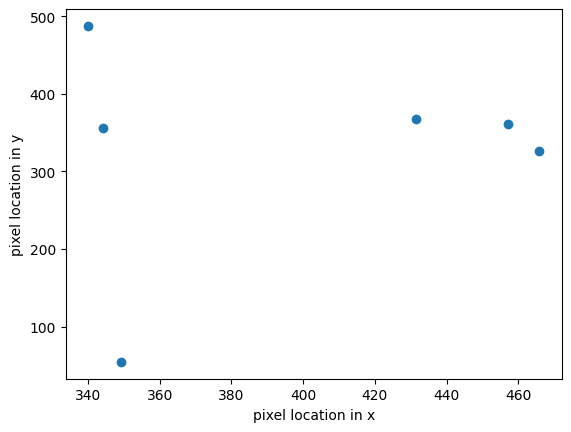

In [25]:
# Step 5: Plot the 2D projected points
plt.scatter(x, y)
plt.xlabel('pixel location in x', fontsize=10)
plt.ylabel('pixel location in y', fontsize=10)

In [26]:
#  function to convert 3D homogeneous points (X, Y, Z, W)
# to 3D Cartesian (X/W, Y/W, Z/W)
def three_dimensional_homo_to_cartesian(points):
    cartesian_coordinates = points[0:3,] / points[3:4,]
    return cartesian_coordinates

In [27]:
# Convert our 3D points to Cartesian for the Hall method
three_d_cartesian = three_dimensional_homo_to_cartesian(three_d_homo)
three_d_cartesian

array([[-276.,   31., -215.,  203.,  -56., -357.],
       [ 421.,  366., -246., -363.,  226.,  377.],
       [-390., -229.,  310., -371.,  313., -409.]])

In [28]:
# Test: grab the (X, Y, Z) of the first point
Xw, Yw, Zw = three_d_cartesian[:, 0]

In [29]:
# Display the first point's coordinates
Xw, Yw, Zw

(-276.0, 421.0, -390.0)

In [30]:
# Step 6: Implement the Hall calibration method
def Hall_method(three_d_cartesian, two_d_cartesian):
    n = three_d_cartesian.shape[1]
    # Initialize the Q matrix (2n x 11) and B vector (2n x 1)
    Q = zeros((2*n, 11))
    B = zeros((2*n, 1))

    # Build the Q and B matrices point by point
    for i in range(n):
        Xw, Yw, Zw = three_d_cartesian[:, i]
        Xu, Yu = two_d_cartesian[:, i]
        # First row for Xu (equation for x-coordinate)
        Q[2*i] = [Xw, Yw, Zw, 1, 0, 0, 0, 0, -Xu*Xw, -Xu*Yw, -Xu*Zw]
        B[2*i] = Xu
        # Second row for Yu (equation for y-coordinate)
        Q[2*i + 1] = [0, 0, 0, 0, Xw, Yw, Zw, 1, -Yu*Xw, -Yu*Yw, -Yu*Zw]
        B[2*i + 1] = Yu

    # We want to solve the system Q * A = B for A (the 11 camera parameters)
    # Since Q is (2n x 11) (e.g., 12x11) and not square, we can't just invert it.
    # linalg.lstsq() finds the "least-squares solution," which is the
    # vector A that best solves this overdetermined system.
    A, residuals, rank, s = linalg.lstsq(Q, B, rcond=None) 
    # The Hall method solves for the first 11 elements of P, assuming P[2,3] = 1.
    # We append this '1' to our solution vector A to get all 12 elements.
    A = append(A, [1])
    # Reshape the 12-element flat vector A into a 12x1 column vector.
    # The '-1' tells numpy to automatically calculate the number of rows
    # needed to make a 1-column matrix.
    A = A.reshape(-1, 1)  # write reasoning for this reshaping function and the parameters that are passed to it
    # Reconstruct the 3x4 P matrix from the 12x1 A vector
    P_recovered = zeros((3,4))
    lower_limit = 0
    upper_limit = 4
    for i in range(3):
        P_recovered[i, :] = A[lower_limit:upper_limit].T
        lower_limit += 4
        upper_limit += 4

    return P_recovered

In [31]:
#Step 6 (continued): Run the Hall method to get the estimated P matrix
P_recovered = Hall_method(three_d_cartesian, two_d_cartesian_coordinates)
# brings the matrix up to scale
P_recovered = P_recovered/P_recovered[2,3]

In [32]:
# Check the shape, should be (3, 4)
P_recovered.shape

(3, 4)

In [33]:
# Step 7: Compare the recovered P with the original P
# linalg.norm() calculates the "Frobenius norm" of the difference matrix.
# This is basically the Euclidean distance between the two matrices,
# giving us a single number to represent the total error.
error = linalg.norm(P_recovered - P) #write the reasoning for using this function in step 7

In [34]:
# Display the original P (for comparison)
P

array([[-3.32440977e-01,  6.23705255e-02, -2.66219008e-01,
         3.63521520e+02],
       [-1.20680016e-01,  4.90343479e-01,  1.02838670e-01,
         2.98667900e+02],
       [ 6.36610019e-05,  3.97783422e-04, -5.31187416e-04,
         1.00000000e+00]])

In [35]:
# Display the error. For noise-free points, this should be very close to 0.
error

1.9961126925334324e-09

In [36]:
#Step 7 (continued): Function to get K and cRw from P

from scipy.linalg import rq

def get_intrinsics_from_proj_matrix(P):
    M = P[:, :3] # M is the left 3x3 submatrix of P

    # Perform RQ decomposition: M = R @ Q
    # R is an upper-triangular matrix (related to K)
    # Q is an orthogonal (rotation) matrix (related to cRw)
    R, Q = rq(M)
    # Check the determinant of Q to make cRw a proper rotation
    if linalg.det(Q) < 0:
        cRw = -Q
    else:
        cRw = Q
    # Get the normalized intrinsics
    K = R / R[2, 2] # Normalize K by the (3,3) element of R
    return K, cRw

In [37]:

# Get the recovered K and cRw from the noise-free estimated P
K_recovered, cRw_recovered = get_intrinsics_from_proj_matrix(P_recovered)

In [38]:
# Display the recovered K matrix. It should be close to the original K.
K_recovered

array([[-5.57094300e+02,  2.60840932e-08,  3.26381900e+02],
       [ 0.00000000e+00, -7.12982400e+02,  2.98667900e+02],
       [ 0.00000000e+00,  0.00000000e+00,  1.00000000e+00]])

In [39]:
# Display the recovered cRw matrix.
cRw_recovered

array([[ 0.95105652,  0.18163563,  0.25      ],
       [ 0.29389263, -0.78165676, -0.55012711],
       [ 0.0954915 ,  0.59667513, -0.79678112]])

In [40]:
# Step 8: Function to add Gaussian noise to the 2D points   
def add_noise_to_2d_cartesian_points(two_d_cartesian_coordinates):
    noise = random.normal(0, 0.5, two_d_cartesian_coordinates.shape)
    two_d_cartesian_coordinates_noisy = two_d_cartesian_coordinates + noise
    return two_d_cartesian_coordinates_noisy

In [41]:
# Create noisy 2D points
two_d_cartesian_coordinates_noisy = add_noise_to_2d_cartesian_points(two_d_cartesian_coordinates)
# Re-run calibration using the noisy points
P_recovered_noisy = Hall_method(three_d_cartesian, two_d_cartesian_coordinates_noisy)
# brings the matrix up to scale
P_recovered_noisy = P_recovered_noisy/P_recovered_noisy[2,3]

In [42]:
# Compare the noisy P with the noise-free P
error = linalg.norm(P_recovered - P_recovered_noisy)

In [43]:
#Display the error. This will be much larger than the noise-free error.
error

0.38759073027235325

In [44]:
# Extract K and cRw from the *noisy* P matrix
K_recovered_noisy, cRw_recovered_noisy = get_intrinsics_from_proj_matrix(P_recovered_noisy)

In [45]:
# Display the K matrix recovered from noisy data.
K_recovered_noisy

array([[-551.62505478,    7.09520782,  295.95495325],
       [   0.        , -717.23444221,  294.06911494],
       [   0.        ,    0.        ,    1.        ]])

In [46]:
# Display the K matrix recovered from noise-free data (for comparison)
K_recovered

array([[-5.57094300e+02,  2.60840932e-08,  3.26381900e+02],
       [ 0.00000000e+00, -7.12982400e+02,  2.98667900e+02],
       [ 0.00000000e+00,  0.00000000e+00,  1.00000000e+00]])

In [47]:
# Step 9: Compute 2D points using the *noisy* P matrix
two_dimensional_homo_noisy_recovered = compute_2d_homogenous_coordinates(P_recovered_noisy, three_d_homo)

In [48]:
# Convert them to Cartesian
two_d_cartesian_coordinates_noisy_recovered = two_dimensional_homo_to_cartesian(two_dimensional_homo_noisy_recovered)

In [49]:
# Display the re-projected 2D points
two_d_cartesian_coordinates_noisy_recovered

array([[431.33345328, 344.43503461, 466.33498826, 350.22698263,
        340.28802378, 457.39907634],
       [367.14661162, 355.59252826, 325.57083795,  54.85894098,
        488.20505852, 360.11780771]])

In [74]:
# Display the original 2D points + noise (for comparison)
two_d_cartesian_coordinates_noisy

array([[431.51701428, 344.46673639, 466.44489891, 350.19576135,
        340.18660397, 457.21906443],
       [367.86964815, 355.43786022, 325.68124928,  54.86391833,
        488.14430592, 359.51233177]])

In [ ]:
# Step 9 (continued): Calculate the average projection error
# This compares the ORIGINAL 2D points (from Step 4) with the
# re-projected 2D points (from Step 9).
# Our points are stored column-wise (shape 2, N), so each column is a point.
# linalg.norm(..., axis=0) computes the Euclidean norm (sqrt(x^2 + y^2))
# for each column, giving us the error for each point.
error_per_point = linalg.norm(two_d_cartesian_coordinates - two_d_cartesian_coordinates_noisy_recovered, axis=0)

# So what does axis=1 mean in this case?
# Given image_pts of shape (N, 2):

# python
# np.linalg.norm(image_pts, axis=1)
# axis=1 means: compute the norm along axis 1 — i.e., across the columns for each row.

# Since each row is [x, y], this computes:

# sqrt(x^2+y^2)
 
# for each point — the Euclidean length of that point from the origin.


# we have N 2D image points.

# Case 1: Row-wise storage (most common)
# python
# image_pts = np.array([
#     [x1, y1],
#     [x2, y2],
#     ...
#     [xN, yN]
# ])  # Shape: (N, 2)
# Each row is a point.

# To compute the norm (e.g., reprojection error) per point, use:

# python
# np.linalg.norm(diff, axis=1)  # → shape (N,)
# because we're taking the norm across columns (axis 1) for each row.

# Case 2: Column-wise storage 
# python
# image_pts = np.array([
#     [x1, x2, ..., xN],
#     [y1, y2, ..., yN]
# ])  # Shape: (2, N)
# Each column is a point
# Now, to compute the norm per point, use:

# python
# np.linalg.norm(diff, axis=0)  # → shape (N,)
# because we're taking the norm down the rows (axis 0) for each column.


In [52]:
# Display the error for each of the 6 points
error_per_point

array([1.17873413, 1.07319326])

In [53]:
# Compute the average of the per-point errors
average_projection_error = mean(error_per_point)
average_projection_error

1.1259636968753624

In [54]:
# Step 10: Repeat the process for 10 points
three_d_ten_points_homo = create_3d_homogenous_coordinates(10)
three_d_ten_points_cartesian = three_dimensional_homo_to_cartesian(three_d_ten_points_homo)
# three_d_ten_points_homo = concatenate((three_d_ten_points, ones((10,1))), axis=1).T
# three_d_ten_points_homo.shape
two_dimensional_ten_points_homo = compute_2d_homogenous_coordinates(P, three_d_ten_points_homo)
two_d_ten_points_cartesian_coordinates = two_dimensional_homo_to_cartesian(two_dimensional_ten_points_homo)

In [55]:
# Add noise to the 10 2D points
two_d_ten_points_cartesian_coordinates_noisy = add_noise_to_2d_cartesian_points(two_d_ten_points_cartesian_coordinates)

In [56]:
# Calibrate using the 10 noisy points
P_recovered_ten_points_noisy = Hall_method(three_d_ten_points_cartesian, two_d_ten_points_cartesian_coordinates_noisy)
# brings the matrix up to scale
P_recovered_ten_points_noisy = P_recovered_ten_points_noisy/P_recovered_ten_points_noisy[2,3]

In [57]:
# Display the recovered P matrix (from 10 points)
P_recovered_ten_points_noisy

array([[-3.34662349e-01,  6.42356983e-02, -2.60764419e-01,
         3.63109388e+02],
       [-1.21592497e-01,  4.92205760e-01,  1.05445451e-01,
         2.99065546e+02],
       [ 6.11673801e-05,  3.99401620e-04, -5.19760661e-04,
         1.00000000e+00]])

In [58]:
# Extract K and cRw from the 10-point noisy P
error_ten_points_noisy = linalg.norm(P_recovered - P_recovered_ten_points_noisy)
error_ten_points_noisy

0.5727348099327346

In [59]:
# Compare the 10-point noisy P to the 6-point noise-free P
K_recovered_ten_points_noisy, cRw_recovered_ten_points_noisy = get_intrinsics_from_proj_matrix(P_recovered_ten_points_noisy)

In [60]:
# Re-project the 10 3D points using the 10-point noisy P
two_dimensional_ten_points_homo_noisy_recovered = compute_2d_homogenous_coordinates(P_recovered_ten_points_noisy, three_d_ten_points_homo)
two_dimensional_ten_points_cartesian_noisy_recovered = two_dimensional_homo_to_cartesian(two_dimensional_ten_points_homo_noisy_recovered)

In [61]:
# Calculate the projection error for each of the 10 points  
error_per_point_ten_point = linalg.norm(two_d_ten_points_cartesian_coordinates - two_dimensional_ten_points_cartesian_noisy_recovered, axis=0)
error_per_point_ten_point

array([1.19717233, 0.24145833, 0.707098  , 0.04502905, 0.92915785,
       0.23270399, 0.61735616, 0.2231688 , 0.2206778 , 0.28883565])

In [62]:
# Calculate the average projection error for 10 points
average_projection_error_ten_points = mean(error_per_point_ten_point)
average_projection_error_ten_points

0.4702657959913332

In [63]:
# Step 10 (continued): Repeat the process for 50 points
three_d_fifty_points_homo = create_3d_homogenous_coordinates(50)
three_d_fifty_points_cartesian = three_dimensional_homo_to_cartesian(three_d_fifty_points_homo)
# three_d_fifty_points_homo.shape
two_dimensional_fifty_points_homo = compute_2d_homogenous_coordinates(P, three_d_fifty_points_homo)
two_d_fifty_points_cartesian_coordinates = two_dimensional_homo_to_cartesian(two_dimensional_fifty_points_homo)

In [64]:
# Add noise to the 50 2D points
two_d_fifty_points_cartesian_coordinates_noisy = add_noise_to_2d_cartesian_points(two_d_fifty_points_cartesian_coordinates)

In [65]:
# Calibrate using the 50 noisy points
P_recovered_fifty_points_noisy = Hall_method(three_d_fifty_points_cartesian, two_d_fifty_points_cartesian_coordinates_noisy)
# brings the matrix up to scale
P_recovered_fifty_points_noisy = P_recovered_fifty_points_noisy/P_recovered_fifty_points_noisy[2,3]

In [66]:
# Extract K and cRw from the 50-point noisy P
K_recovered_fifty_points_noisy, cRw_recovered_fifty_points_noisy = get_intrinsics_from_proj_matrix(P_recovered_fifty_points_noisy)

In [67]:
# Compare the 50-point noisy P to the 6-point noise-free P
error_fifty_points_noisy = linalg.norm(P_recovered - P_recovered_fifty_points_noisy)
error_fifty_points_noisy

0.0781467533033131

In [68]:
# Re-project the 50 3D points using the 50-point noisy P
two_dimensional_fifty_points_homo_noisy_recovered = compute_2d_homogenous_coordinates(P_recovered_fifty_points_noisy, three_d_fifty_points_homo)
two_dimensional_fifty_points_cartesian_noisy_recovered = two_dimensional_homo_to_cartesian(two_dimensional_fifty_points_homo_noisy_recovered)

In [69]:
# Calculate the projection error for each of the 50 points
error_per_point_fifty_point = linalg.norm(two_d_fifty_points_cartesian_coordinates - two_dimensional_fifty_points_cartesian_noisy_recovered, axis=0)
error_per_point_fifty_point

array([0.13660495, 0.20502656, 0.09328178, 0.13284043, 0.27013828,
       0.15342742, 0.44317932, 0.19764977, 0.0894594 , 0.10491079,
       0.0793139 , 0.30234644, 0.22594517, 0.44554043, 0.04845685,
       0.40180228, 0.25176185, 0.08965455, 0.06674073, 0.37642192,
       0.21586504, 0.15639299, 0.17796328, 0.14845036, 0.56005501,
       0.50781511, 0.07708239, 0.11830099, 0.06135565, 0.25794223,
       0.14053834, 0.13195091, 0.34422044, 0.14937983, 0.20065911,
       0.05297919, 0.3813218 , 0.25277741, 0.11621975, 0.24954326,
       0.15953415, 0.11739235, 0.06422248, 0.2268351 , 0.2215925 ,
       0.18569977, 0.23157573, 0.20897413, 0.14790231, 0.07768037])

In [70]:
# Calculate the average projection error for 50 points
average_projection_error_fifty_points = mean(error_per_point_fifty_point)
average_projection_error_fifty_points

0.2011344956031029

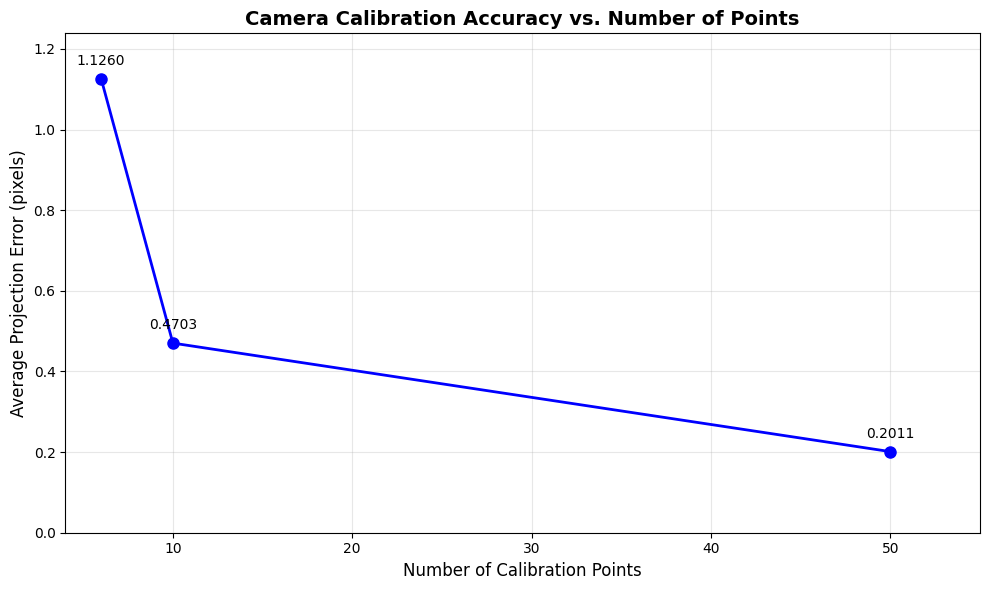

In [71]:
# Visualize accuracy vs. number of points
point_counts = [6, 10, 50]
# Get the average errors we calculated in cells 53, 62, and 70
errors = [average_projection_error, average_projection_error_ten_points, average_projection_error_fifty_points] 

# Plot showing that more points reduce calibration error
plt.figure(figsize=(10, 6))
plt.plot(point_counts, errors, 'bo-', linewidth=2, markersize=8)


plt.xlabel('Number of Calibration Points', fontsize=12)
plt.ylabel('Average Projection Error (pixels)', fontsize=12)
plt.title('Camera Calibration Accuracy vs. Number of Points', fontsize=14, fontweight='bold')

plt.grid(True, alpha=0.3)

for i, (x, y) in enumerate(zip(point_counts, errors)):
    plt.annotate(f'{y:.4f}', (x, y), xytext=(0, 10), 
                textcoords='offset points', ha='center', fontsize=10)


plt.xlim(min(point_counts) - 2, max(point_counts) + 5)
plt.ylim(0, max(errors) * 1.1)

plt.tight_layout()
plt.show()


In [72]:
# Cell 74
# This cell calculates the error (Euclidean distance) between the
# ORIGINAL K/cRw and the RECOVERED K/cRw matrices from all scenarios.
# This helps answer how the parameters change with noise.

# --- Noise-Free vs. Original ---
#normal recovered
error_in_K_6points_compared_to_original = linalg.norm(K_recovered - K)
error_in_cRw_6points_compared_to_original = linalg.norm(cRw_recovered - cRw)
print(f"This is the error in K recovered from 6 points {error_in_K_6points_compared_to_original} when compared to original")
print(f"This is the error in cRw recovered from 6 points {error_in_cRw_6points_compared_to_original} when compared to original")

#noisy recovered - 6points
error_in_K_6points_compared_to_original_noisy = linalg.norm(K_recovered_noisy - K)
error_in_cRw_6points_compared_to_original_noisy = linalg.norm(cRw_recovered_noisy - cRw)
print(f"This is the error in K recovered from 6 points with noise {error_in_K_6points_compared_to_original_noisy} when compared to original")
print(f"This is the error in cRw recovered from 6 points with noise {error_in_cRw_6points_compared_to_original_noisy} when compared to original")

error_in_K_6points_compared_to_recovered_noisy = linalg.norm(K_recovered_noisy - K_recovered)
error_in_cRw_6points_compared_to_recovered_noisy = linalg.norm(cRw_recovered_noisy - cRw_recovered)
print(f"This is the error in K recovered from 6 points with noise {error_in_K_6points_compared_to_recovered_noisy} when compared to normal recovered")
print(f"This is the error in cRw recovered from 6 points with noise {error_in_cRw_6points_compared_to_recovered_noisy} when compared to normal recovered")

#noisy recovered - 10points
error_in_K_10points_compared_to_original_noisy = linalg.norm(K_recovered_ten_points_noisy - K)
error_in_cRw_10points_compared_to_original_noisy = linalg.norm(cRw_recovered_ten_points_noisy - cRw)
print(f"This is the error in K recovered from 10 points with noise {error_in_K_10points_compared_to_original_noisy} when compared to original")
print(f"This is the error in cRw recovered from 10 points with noise {error_in_cRw_10points_compared_to_original_noisy} when compared to original") 

error_in_K_10points_compared_to_recovered_noisy = linalg.norm(K_recovered_ten_points_noisy - K_recovered)
error_in_cRw_10points_compared_to_recovered_noisy = linalg.norm(cRw_recovered_ten_points_noisy - cRw_recovered)
print(f"This is the error in K recovered from 10 points with noise {error_in_K_10points_compared_to_recovered_noisy} when compared to normal recovered")
print(f"This is the error in cRw recovered from 10 points with noise {error_in_cRw_10points_compared_to_recovered_noisy} when compared to normal recovered")

#noisy recovered - 50points
error_in_K_50points_compared_to_original_noisy = linalg.norm(K_recovered_fifty_points_noisy - K)
error_in_cRw_50points_compared_to_original_noisy = linalg.norm(cRw_recovered_fifty_points_noisy - cRw)
print(f"This is the error in K recovered from 50 points with noise {error_in_K_50points_compared_to_original_noisy} when compared to original")
print(f"This is the error in cRw recovered from 50 points with noise {error_in_cRw_50points_compared_to_original_noisy} when compared to original")

error_in_K_50points_compared_to_recovered_noisy = linalg.norm(K_recovered_fifty_points_noisy - K_recovered)
error_in_cRw_50points_compared_to_recovered_noisy = linalg.norm(cRw_recovered_fifty_points_noisy - cRw_recovered)
print(f"This is the error in K recovered from 50 points with noise {error_in_K_50points_compared_to_recovered_noisy} when compared to normal recovered")
print(f"This is the error in cRw recovered from 50 points with noise {error_in_cRw_50points_compared_to_recovered_noisy} when compared to normal recovered")


This is the error in K recovered from 6 points 1809.6385958060407 when compared to original
This is the error in cRw recovered from 6 points 2.4175387712595584 when compared to original
This is the error in K recovered from 6 points with noise 1809.9105263182614 when compared to original
This is the error in cRw recovered from 6 points with noise 2.417631593329974 when compared to original
This is the error in K recovered from 6 points with noise 32.330827491957706 when compared to normal recovered
This is the error in cRw recovered from 6 points with noise 0.07803758611665178 when compared to normal recovered
This is the error in K recovered from 10 points with noise 1822.4910639103125 when compared to original
This is the error in cRw recovered from 10 points with noise 2.4173953135116246 when compared to original
This is the error in K recovered from 10 points with noise 17.586871398312674 when compared to normal recovered
This is the error in cRw recovered from 10 points with noise